In [1]:
import pandas as pd
import numpy as np

import pymongo
from pymongo import MongoClient

from pymongo import MongoClient
from pymongo.database import Database
from pymongo.server_api import ServerApi


import seaborn as sns
import matplotlib.pyplot as plt

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

import dotenv
from dotenv import load_dotenv
load_dotenv()

import sys 
import os
import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath("../src"))   
import soporte_preprocesamiento as f
import soporte_carga as m

pd.set_option('display.max_columns', None)

In [8]:
df = pd.read_csv("../datos/red_piso/Datos_extraccion/datos_provincias_sin_duplicados.csv", index_col=0)

In [9]:
df.head()

,Ascensor,Metros,Año de construcción,Acceso minusválidos,Metros útiles,Dormitorios,Agua caliente,provincia,Baños,Exterior,Trastero,Orientación,Amueblado,Calefacción,Precio,Antigüedad,Cocina equipada,Número de terrazas,Garajes,Tipo de suelo,Tipo de fachada,Circuito cerrado de seguridad,Puerta de seguridad,Aire acondicionado,Estado,Permite mascotas,Cal. energética:,Comunidad,Piscina,Armarios,Alarma,Plantas,Zonas verdes,Pareado,Pisos,Individual,Pista de tenis,Conserje,Pista de fútbol,Adosado,Pista de baloncesto,Consumo,Inquilinos,Emisiones,Campo de golf,Pista de pádel,Cal. energética,Pista de squash,Gimnasio,Salida de humos,Unnamed: 51
0,Si,142.0,1974.0,Si,120.0,3.0,Central,albacete,2.0,Si,Si,Oeste,Si,Central,249000,Mas de 25 Años,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Si,137.0,1974.0,Si,136.0,3.0,Individual,albacete,2.0,Si,NaN,Noreste,Si,Individual,250000,NaN,Si,1.0,1.0,Parquet,Piedra,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Si,96.0,1987.0,Si,95.0,3.0,Individual,albacete,2.0,NaN,NaN,NaN,Si,Individual,A consultar,NaN,Si,NaN,NaN,Parquet,Ladrillo,Si,Si,Si,Perfecto Estado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,50.0,NaN,Si,40.0,1.0,Individual,alicante,1.0,Si,NaN,NaN,Si,Individual,85000,Entre 35 y 50 Años,Si,NaN,NaN,Gres,Cemento,NaN,NaN,Si,Perfecto Estado,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,64.0,1968.0,NaN,58.0,3.0,Individual,alicante,1.0,Si,Si,Sureste,NaN,Eléctrica,105000,Más de 50 años,NaN,1.0,NaN,Gres,Cemento,NaN,Si,NaN,Perfecto Estado,NaN,Si,"30,00 €",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**TRATAR LOS NOMBRES DE LAS COLUMNAS PARA QUE ESTÉN SIN ESPACIOS NI MAYÚSCULAS**

In [10]:
df.columns=df.columns.str.lower().str.replace(" ","_").str.replace("á","a").str.replace("é","e").str.replace("í","i").str.replace("ó","o").str.replace("ú","u")

In [11]:
df.columns

Index(['ascensor', 'metros', 'año_de_construccion', 'acceso_minusvalidos',
       'metros_utiles', 'dormitorios', 'agua_caliente', 'provincia', 'baños',
       'exterior', 'trastero', 'orientacion', 'amueblado', 'calefaccion',
       'precio', 'antigüedad', 'cocina_equipada', 'numero_de_terrazas',
       'garajes', 'tipo_de_suelo', 'tipo_de_fachada',
       'circuito_cerrado_de_seguridad', 'puerta_de_seguridad',
       'aire_acondicionado', 'estado', 'permite_mascotas', 'cal._energetica:',
       'comunidad', 'piscina', 'armarios', 'alarma', 'plantas', 'zonas_verdes',
       'pareado', 'pisos', 'individual', 'pista_de_tenis', 'conserje',
       'pista_de_futbol', 'adosado', 'pista_de_baloncesto', 'consumo',
       'inquilinos', 'emisiones', 'campo_de_golf', 'pista_de_padel',
       'cal._energetica', 'pista_de_squash', 'gimnasio', 'salida_de_humos',
       'unnamed:_51'],
      dtype='object')

**No hay duplicados aunque luego surjan por no hacer uso de algunas columnas**

In [12]:
df.duplicated().sum()

np.int64(0)

**Los siguientes datos habrá que calcularlos con la información de la que disponemos:**  
- ccaa	 
- ayudas_ccaa	
- bonificaciones	
- radiacion_solar	

Debemos convertir la columna de provincia para poder usar los métodos que se usaron para la alimentación del data frame de EF (ayudas_ccaa, bonificaciones y radiación solar)

In [13]:
df["provincia"].value_counts()

provincia
madrid         2880
murcia          169
guadalajara     133
toledo          117
zaragoza        101
alicante         79
sevilla          71
cádiz            68
valencia         60
tenerife         57
barcelona        51
castellón        45
córdoba          12
granada          11
ávila             9
segovia           9
cuenca            3
albacete          3
lleida            2
burgos            1
huesca            1
huelva            1
ourense           1
palencia          1
Name: count, dtype: int64

In [14]:
lista_provincias=df["provincia"].unique()

Para las provincias, tengo que poner la primera letra en mayúscula y tenerife cambiarlo por Santa Cruz de Tenerife

In [15]:
# aplico la función a la columna 'provincia'
df['idq_pv'] = df['provincia'].apply(f.formatear_provincia)
df.drop(columns=["provincia"],inplace=True)

In [16]:
df["idq_pv"].unique()

array(['Albacete', 'Alicante', 'Ávila', 'Barcelona', 'Burgos', 'Cádiz',
       'Castellón', 'Córdoba', 'Cuenca', 'Granada', 'Guadalajara',
       'Huelva', 'Huesca', 'Lleida', 'Madrid', 'Murcia', 'Ourense',
       'Palencia', 'Santa Cruz de Tenerife', 'Segovia', 'Sevilla',
       'Toledo', 'Valencia', 'Zaragoza'], dtype=object)

Creo la columna de ccaa

In [17]:
provincias_ccaa = {
    "Álava": "País Vasco",
    "Albacete": "Castilla-La Mancha",
    "Alicante": "Comunidad Valenciana",
    "Almería": "Andalucía",
    "Ávila": "Castilla y León",
    "Badajoz": "Extremadura",
    "Baleares": "Islas Baleares",
    "Barcelona": "Cataluña",
    "Burgos": "Castilla y León",
    "Cáceres": "Extremadura",
    "Cádiz": "Andalucía",
    "Castellón": "Comunidad Valenciana",
    "Ciudad Real": "Castilla-La Mancha",
    "Córdoba": "Andalucía",
    "Coruña": "Galicia",
    "Cuenca": "Castilla-La Mancha",
    "Girona": "Cataluña",
    "Granada": "Andalucía",
    "Guadalajara": "Castilla-La Mancha",
    "Gipuzkoa": "País Vasco",
    "Huelva": "Andalucía",
    "Huesca": "Aragón",
    "Jaén": "Andalucía",
    "León": "Castilla y León",
    "Lleida": "Cataluña",
    "La Rioja": "La Rioja",
    "Lugo": "Galicia",
    "Madrid": "Madrid",
    "Málaga": "Andalucía",
    "Murcia": "Murcia",
    "Navarra": "Navarra",
    "Ourense": "Galicia",
    "Asturias": "Asturias",
    "Palencia": "Castilla y León",
    "Las Palmas": "Islas Canarias",
    "Pontevedra": "Galicia",
    "Salamanca": "Castilla y León",
    "Santa Cruz de Tenerife": "Islas Canarias",
    "Cantabria": "Cantabria",
    "Segovia": "Castilla y León",
    "Sevilla": "Andalucía",
    "Soria": "Castilla y León",
    "Tarragona": "Cataluña",
    "Teruel": "Aragón",
    "Toledo": "Castilla-La Mancha",
    "Valencia": "Comunidad Valenciana",
    "Valladolid": "Castilla y León",
    "Bizkaia": "País Vasco",
    "Zamora": "Castilla y León",
    "Zaragoza": "Aragón",
    "Ceuta": "Ceuta",
    "Melilla": "Melilla"
}

df["ccaa"] = df['idq_pv'].map(provincias_ccaa)


In [18]:
df["ccaa"].unique()

array(['Castilla-La Mancha', 'Comunidad Valenciana', 'Castilla y León',
       'Cataluña', 'Andalucía', 'Aragón', 'Madrid', 'Murcia', 'Galicia',
       'Islas Canarias'], dtype=object)

Creo la columna de tipo de edificio

In [19]:
df["individual"].isna().sum()   

np.int64(3688)

In [20]:
df["adosado"].isna().sum()

np.int64(3692)

Importante saber:  
- Adosado e Individual son viviendas unifamiliares (unir en una columna (aunque luego se va a eliminar))    

In [21]:
df["individual"].value_counts()

individual
Si    197
Name: count, dtype: int64

In [22]:
df["adosado"].value_counts()

adosado
Si    193
Name: count, dtype: int64

In [23]:
df["tipoedif"] = np.where((df["adosado"] == "Si") | (df["individual"] == "Si"), "Unifamiliar", "Multifamiliar")

In [24]:
df["tipoedif"].value_counts()

tipoedif
Multifamiliar    3495
Unifamiliar       390
Name: count, dtype: int64

Creo la columna de ayudas_ccaa

In [25]:
ayudas_ccaa = {
    ("Andalucía", "Unifamiliar"): 3000,
    ("Andalucía", "Multifamiliar"): 6000,
    ("Aragón", "Unifamiliar"): 4000,
    ("Aragón", "Multifamiliar"): 6000,
    ("Asturias", "Unifamiliar"): 3500,
    ("Asturias", "Multifamiliar"): 5500,
    ("Cantabria", "Unifamiliar"): 3200,
    ("Cantabria", "Multifamiliar"): 4800,
    ("Castilla y León", "Unifamiliar"): 3800,
    ("Castilla y León", "Multifamiliar"): 5500,
    ("Castilla-La Mancha", "Unifamiliar"): 3000,
    ("Castilla-La Mancha", "Multifamiliar"): 4500,
    ("Cataluña", "Unifamiliar"): 6000,
    ("Cataluña", "Multifamiliar"): 9000,
    ("Comunidad Valenciana", "Unifamiliar"): 4000,
    ("Comunidad Valenciana", "Multifamiliar"): 6000,
    ("Extremadura", "Unifamiliar"): 3500,
    ("Extremadura", "Multifamiliar"): 5500,
    ("Galicia", "Unifamiliar"): 4000,
    ("Galicia", "Multifamiliar"): 5000,
    ("Islas Baleares", "Unifamiliar"): 4500,
    ("Islas Baleares", "Multifamiliar"): 6000,
    ("Islas Canarias", "Unifamiliar"): 5000,
    ("Islas Canarias", "Multifamiliar"): 6000,
    ("La Rioja", "Unifamiliar"): 3600,
    ("La Rioja", "Multifamiliar"): 5400,
    ("Madrid", "Unifamiliar"): 5000,
    ("Madrid", "Multifamiliar"): 7000,     
    ("Murcia", "Unifamiliar"): 3200,
    ("Murcia", "Multifamiliar"): 4500,
    ("Navarra", "Unifamiliar"): 4500,
    ("Navarra", "Multifamiliar"): 6000,
    ("País Vasco", "Unifamiliar"): 4800,
    ("País Vasco", "Multifamiliar"): 6200,
    ("Ceuta", "Unifamiliar"): 3000,
    ("Ceuta", "Multifamiliar"): 4500,
    ("Melilla", "Unifamiliar"): 3000,
    ("Melilla", "Multifamiliar"): 4500                                    
}


df['ayudas_ccaa'] = df.apply(lambda x: ayudas_ccaa.get((x['ccaa'], x['tipoedif']), 0), axis=1)


Creo la columna de bonificaciones donde vale 0 si no disfruta ni de beneficcios en el IBI ni en ICIO, 1 si se beneficia únicamente de bonificaciones del IBI y 2 si se beneficia de ambos.

In [26]:
bonificaciones_ccaa = {
    "Andalucía": "IBI y ICIO",
    "Aragón": "IBI",
    "Asturias": "IBI",
    "Cantabria": "IBI",
    "Castilla y León": "IBI",
    "Castilla-La Mancha": "IBI y ICIO",
    "Cataluña": "IBI",
    "Comunidad Valenciana": "IBI y ICIO",
    "Extremadura": "IBI",
    "Galicia": "IBI y ICIO",
    "Islas Baleares": "IBI y ICIO",
    "Islas Canarias": "IBI y ICIO",
    "La Rioja": "IBI",
    "Madrid": "IBI y ICIO",     
    "Murcia": "IBI",
    "Navarra": "IBI",
    "País Vasco": "IBI",
    "Ceuta": "Ninguna",
    "Melilla": "Ninguna"                                    
}

df["bonificaciones"] = df['ccaa'].map(bonificaciones_ccaa)

Creo la columna de radiación solar.

In [27]:
datos_radiaciones=pd.read_pickle("../datos/EF/Datos_alimentados/radiaciones.pkl")

In [28]:
diccionario_rad = datos_radiaciones.set_index('Provincias')[['Horas de sol', 'HSP*']].to_dict(orient='index')

In [29]:
df['radiacion_solar'] = df['idq_pv'].map(lambda x: diccionario_rad[x]['HSP*'])

In [30]:
df.sample(4)

,ascensor,metros,año_de_construccion,acceso_minusvalidos,metros_utiles,dormitorios,agua_caliente,baños,exterior,trastero,orientacion,amueblado,calefaccion,precio,antigüedad,cocina_equipada,numero_de_terrazas,garajes,tipo_de_suelo,tipo_de_fachada,circuito_cerrado_de_seguridad,puerta_de_seguridad,aire_acondicionado,estado,permite_mascotas,cal._energetica:,comunidad,piscina,armarios,alarma,plantas,zonas_verdes,pareado,pisos,individual,pista_de_tenis,conserje,pista_de_futbol,adosado,pista_de_baloncesto,consumo,inquilinos,emisiones,campo_de_golf,pista_de_padel,cal._energetica,pista_de_squash,gimnasio,salida_de_humos,unnamed:_51,idq_pv,ccaa,tipoedif,ayudas_ccaa,bonificaciones,radiacion_solar
1355,Si,115.0,1959.0,NaN,95.0,2.0,Gas natural,2.0,Si,NaN,NaN,Si,Gas Natural,525000,NaN,Si,NaN,NaN,Tarima Flotante,Ladrillo,NaN,Si,Si,Perfecto Estado,NaN,Si,NaN,NaN,4.0,NaN,5.0,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,326 KW h/m² año,NaN,64 Kg CO2/m² año,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,Madrid,Multifamiliar,7000,IBI y ICIO,5.74
1824,Si,84.0,1974.0,Si,75.0,3.0,Individual,1.0,Si,NaN,Suroeste,NaN,Central,217000,Entre 35 y 50 Años,Si,1.0,NaN,Tarima normal,Ladrillo,Si,Si,NaN,NaN,NaN,Si,"130,00 €",NaN,2.0,NaN,10.0,Si,NaN,40.0,NaN,NaN,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,Madrid,Multifamiliar,7000,IBI y ICIO,5.74
517,Si,86.0,1987.0,NaN,NaN,3.0,NaN,1.0,Si,NaN,NaN,NaN,Individual,269000,Entre 35 y 50 Años,NaN,NaN,1.0,Parquet,Ladrillo,NaN,NaN,NaN,NaN,NaN,Si,"190,00 €",NaN,NaN,NaN,3.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,Madrid,Multifamiliar,7000,IBI y ICIO,5.74
1343,Si,120.0,1965.0,Si,97.0,4.0,Individual,2.0,Si,NaN,Este,NaN,Central,510000,Más de 50 años,Si,1.0,1.0,Parquet,Ladrillo,NaN,Si,Si,NaN,NaN,Si,"100,00 €",NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Si,NaN,NaN,NaN,349 KW h/m² año,NaN,59 Kg CO2/m² año,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,Madrid,Multifamiliar,7000,IBI y ICIO,5.74


Creo la columna que indica si el agua caliente es central o no.

In [31]:
# df["aguacalcent"] = np.where(df["agua_caliente"].isna(),"Desconocido", np.where(df["agua_caliente"] == "Central", "Si","No"))     Esto por si quiero generar una categoria para los nulos

In [32]:
df["aguacalcent"] = np.where(df["agua_caliente"] == "Central", "Si", "No")
df.drop(columns=["agua_caliente"], inplace=True)

Creo la columna que especifica la calefaccion del hogar.

In [33]:
df["calefac"] = np.where(df["calefaccion"].isin(["Central", "Colectiva"]),"Colectiva",
                         np.where(df["calefaccion"].isin(["Individual", "Eléctrica", "Gas Natural", "Gasóleo", "Propano", "Aerotermia", "Biomasa", "Suelo Radiante"]),"Individual","No tiene calefacción"))
df.drop(columns=["calefaccion"], inplace=True)

## **HACEMOS LA CARGA DE LOS DATOS**

In [2]:
m.probar_con_atlas()

Pinged your deployment. You successfully connected to MongoDB!


In [4]:
cliente, db=m.conectar_mongo()

In [ ]:
# m.insertar_en_coleccion(db,"Housing_Prices",df)  #Lo dejo comentado para que no se dupliquen los datos cada vez que corro todo

✅ Datos insertados o actualizados en la colección 'Housing_Prices' correctamente.


In [30]:
df.head(1)

,ascensor,metros,año_de_construccion,acceso_minusvalidos,metros_utiles,dormitorios,baños,exterior,trastero,orientacion,amueblado,precio,antigüedad,cocina_equipada,numero_de_terrazas,garajes,tipo_de_suelo,tipo_de_fachada,circuito_cerrado_de_seguridad,puerta_de_seguridad,aire_acondicionado,estado,permite_mascotas,cal._energetica:,comunidad,piscina,armarios,alarma,plantas,zonas_verdes,pareado,pisos,individual,pista_de_tenis,conserje,pista_de_futbol,adosado,pista_de_baloncesto,consumo,inquilinos,emisiones,campo_de_golf,pista_de_padel,cal._energetica,pista_de_squash,gimnasio,salida_de_humos,unnamed:_51,idq_pv,ccaa,tipoedif,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac
0,Si,142.0,1974.0,Si,120.0,3.0,2.0,Si,Si,Oeste,Si,249000,Mas de 25 Años,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Albacete,Castilla-La Mancha,Multifamiliar,4500,IBI y ICIO,5.72,Si,Colectiva


In [35]:
columnas_a_traer = {               #pongo 1 para incluirla y 0 para excluir 
    "ascensor":1,
    "metros": 1,
    "metros_utiles": 1,
    "año_de_construccion": 1,
    "antigüedad": 1,
    "acceso_minusvalidos":1,
    "dormitorios": 1,
    "aguacalcent": 1,  
    "idq_pv": 1,
    "ccaa": 1,
    "baños": 1,
    "calefac":1,
    "precio":1,
    "garajes": 1,
    "estado": 1,
    "ayudas_ccaa":1,
    "bonificaciones":1,
    "radiacion_solar":1,
    "_id": 0

}

collection=db["Housing_Prices"]
datos_filtrados = list(collection.find({}, columnas_a_traer))    #filtro las columnas que se necesitan para aplicar los modelos predictivos
cliente.close()
df_filtrado = pd.DataFrame(datos_filtrados)


In [32]:
df["garajes"].value_counts()

garajes
1.0     955
2.0     206
3.0      30
4.0      19
5.0       6
6.0       4
9.0       3
10.0      2
7.0       1
8.0       1
Name: count, dtype: int64

In [33]:
df_filtrado.head()

,ascensor,metros,año_de_construccion,acceso_minusvalidos,metros_utiles,dormitorios,baños,precio,antigüedad,garajes,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac
0,Si,142.0,1974.0,Si,120.0,3.0,2.0,249000,Mas de 25 Años,NaN,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,Si,Colectiva
1,Si,137.0,1974.0,Si,136.0,3.0,2.0,250000,NaN,1.0,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual
2,Si,96.0,1987.0,Si,95.0,3.0,2.0,A consultar,NaN,NaN,Perfecto Estado,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual
3,NaN,50.0,NaN,Si,40.0,1.0,1.0,85000,Entre 35 y 50 Años,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual
4,NaN,64.0,1968.0,NaN,58.0,3.0,1.0,105000,Más de 50 años,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual


# **EDA**

In [34]:
f.exploracion_dataframe(df_filtrado, "dormitorios")

El número de datos es 3885 y el de columnas es 18

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 8

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos
ascensor,41.287001
metros,0.205920
año_de_construccion,18.893179
acceso_minusvalidos,68.365508
metros_utiles,23.371943
dormitorios,1.029601
baños,0.411840
antigüedad,10.604891
garajes,68.416988
estado,15.598456



 ..................... 

Los tipos de las columnas son:


,tipo_dato
ascensor,object
metros,float64
año_de_construccion,float64
acceso_minusvalidos,object
metros_utiles,float64
dormitorios,float64
baños,float64
precio,object
antigüedad,object
garajes,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna ASCENSOR tiene los siguientes valores únicos:
Mostrando 1 categorías con más valores del total de 1 categorías (1/1)


,count
ascensor,
Si,2281


La columna ACCESO_MINUSVALIDOS tiene los siguientes valores únicos:
Mostrando 1 categorías con más valores del total de 1 categorías (1/1)


,count
acceso_minusvalidos,
Si,1229


La columna PRECIO tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 822 categorías (5/822)


,count
precio,
A consultar,546
210000,39
220000,38
150000,38
250000,37


La columna ANTIGÜEDAD tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 9 categorías (5/9)


,count
antigüedad,
Más de 50 años,1302
Entre 35 y 50 Años,789
Mas de 25 Años,422
Entre 15 y 20 Años,267
Entre 20 y 25 Años,262


La columna ESTADO tiene los siguientes valores únicos:
Mostrando 4 categorías con más valores del total de 4 categorías (4/4)


,count
estado,
Perfecto Estado,2335
A reformar,700
Depende del precio,219
Obra nueva,25


La columna IDQ_PV tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 24 categorías (5/24)


,count
idq_pv,
Madrid,2880
Murcia,169
Guadalajara,133
Toledo,117
Zaragoza,101


La columna CCAA tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 10 categorías (5/10)


,count
ccaa,
Madrid,2880
Castilla-La Mancha,256
Comunidad Valenciana,184
Murcia,169
Andalucía,163


La columna BONIFICACIONES tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
bonificaciones,
IBI y ICIO,3541
IBI,344


La columna AGUACALCENT tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
aguacalcent,
No,3566
Si,319


La columna CALEFAC tiene los siguientes valores únicos:
Mostrando 3 categorías con más valores del total de 3 categorías (3/3)


,count
calefac,
Individual,2457
No tiene calefacción,932
Colectiva,496



----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
metros,3877.0,112.415785,208.065700,15.0,69.00,88.00,117.00,7500.00
año_de_construccion,3151.0,1973.934624,338.068772,1.0,1964.00,1974.00,1995.00,19769.00
metros_utiles,2977.0,91.427612,147.216657,12.0,60.00,75.00,96.00,7499.00
dormitorios,3845.0,2.884785,1.079797,1.0,2.00,3.00,3.00,20.00
baños,3869.0,1.551822,0.736277,1.0,1.00,1.00,2.00,7.00
garajes,1227.0,1.343928,0.897187,1.0,1.00,1.00,1.00,10.00
ayudas_ccaa,3885.0,6423.423423,1106.577152,3000.0,6000.00,7000.00,7000.00,9000.00
radiacion_solar,3885.0,5.728790,0.089073,4.8,5.74,5.74,5.74,6.02



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
ascensor,2281,1,Si,2281
acceso_minusvalidos,1229,1,Si,1229
precio,3885,822,A consultar,546
antigüedad,3473,9,Más de 50 años,1302
estado,3279,4,Perfecto Estado,2335
idq_pv,3885,24,Madrid,2880
ccaa,3885,10,Madrid,2880
bonificaciones,3885,2,IBI y ICIO,3541
aguacalcent,3885,2,No,3566
calefac,3885,3,Individual,2457



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ascensor             2281 non-null   object 
 1   metros               3877 non-null   float64
 2   año_de_construccion  3151 non-null   float64
 3   acceso_minusvalidos  1229 non-null   object 
 4   metros_utiles        2977 non-null   float64
 5   dormitorios          3845 non-null   float64
 6   baños                3869 non-null   float64
 7   precio               3885 non-null   object 
 8   antigüedad           3473 non-null   object 
 9   garajes              1227 non-null   float64
 10  estado               3279 non-null   object 
 11  idq_pv               3885 non-null   object 
 12  ccaa                 3885 non-null   object 
 13  ayudas_ccaa          3885 non-null   int64  
 14  bonificaciones       388

None

Lo que he podido ver hasta el momento es que a simple vista parece haber outliers ya que se distorsiona muy levemente la media

VEO LA DISTRIBUCIÓN DE LAS VARIABLES NUMÉRICAS

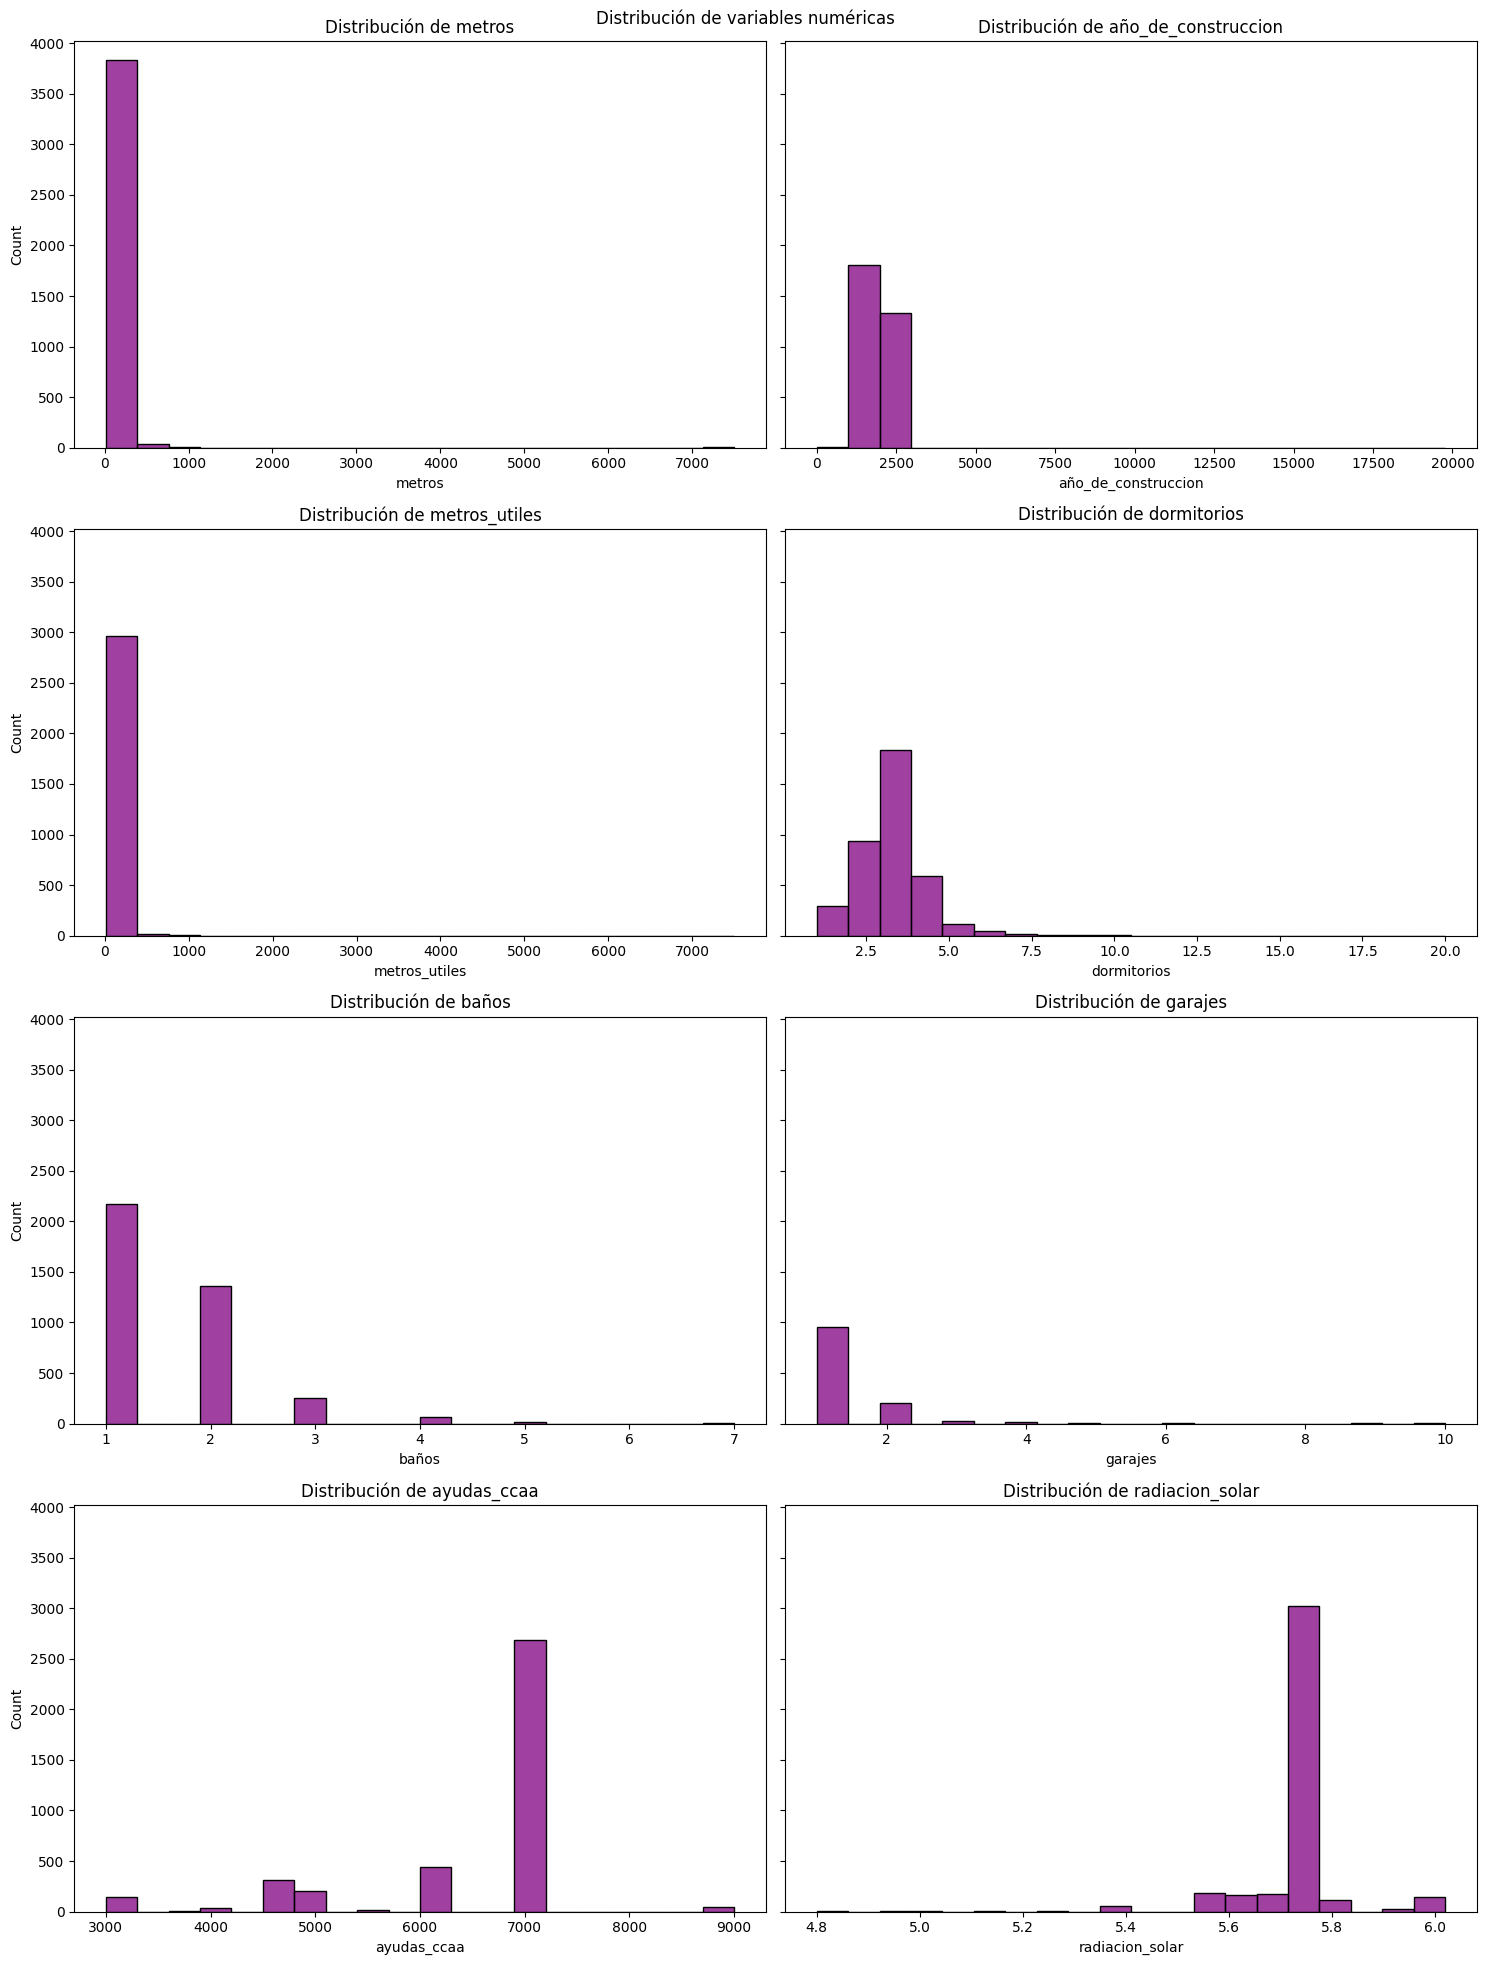

In [35]:
visualizador=f.Visualizador(df_filtrado)
visualizador.plot_numericas(color="purple", tamano_grafica=(15, 20))

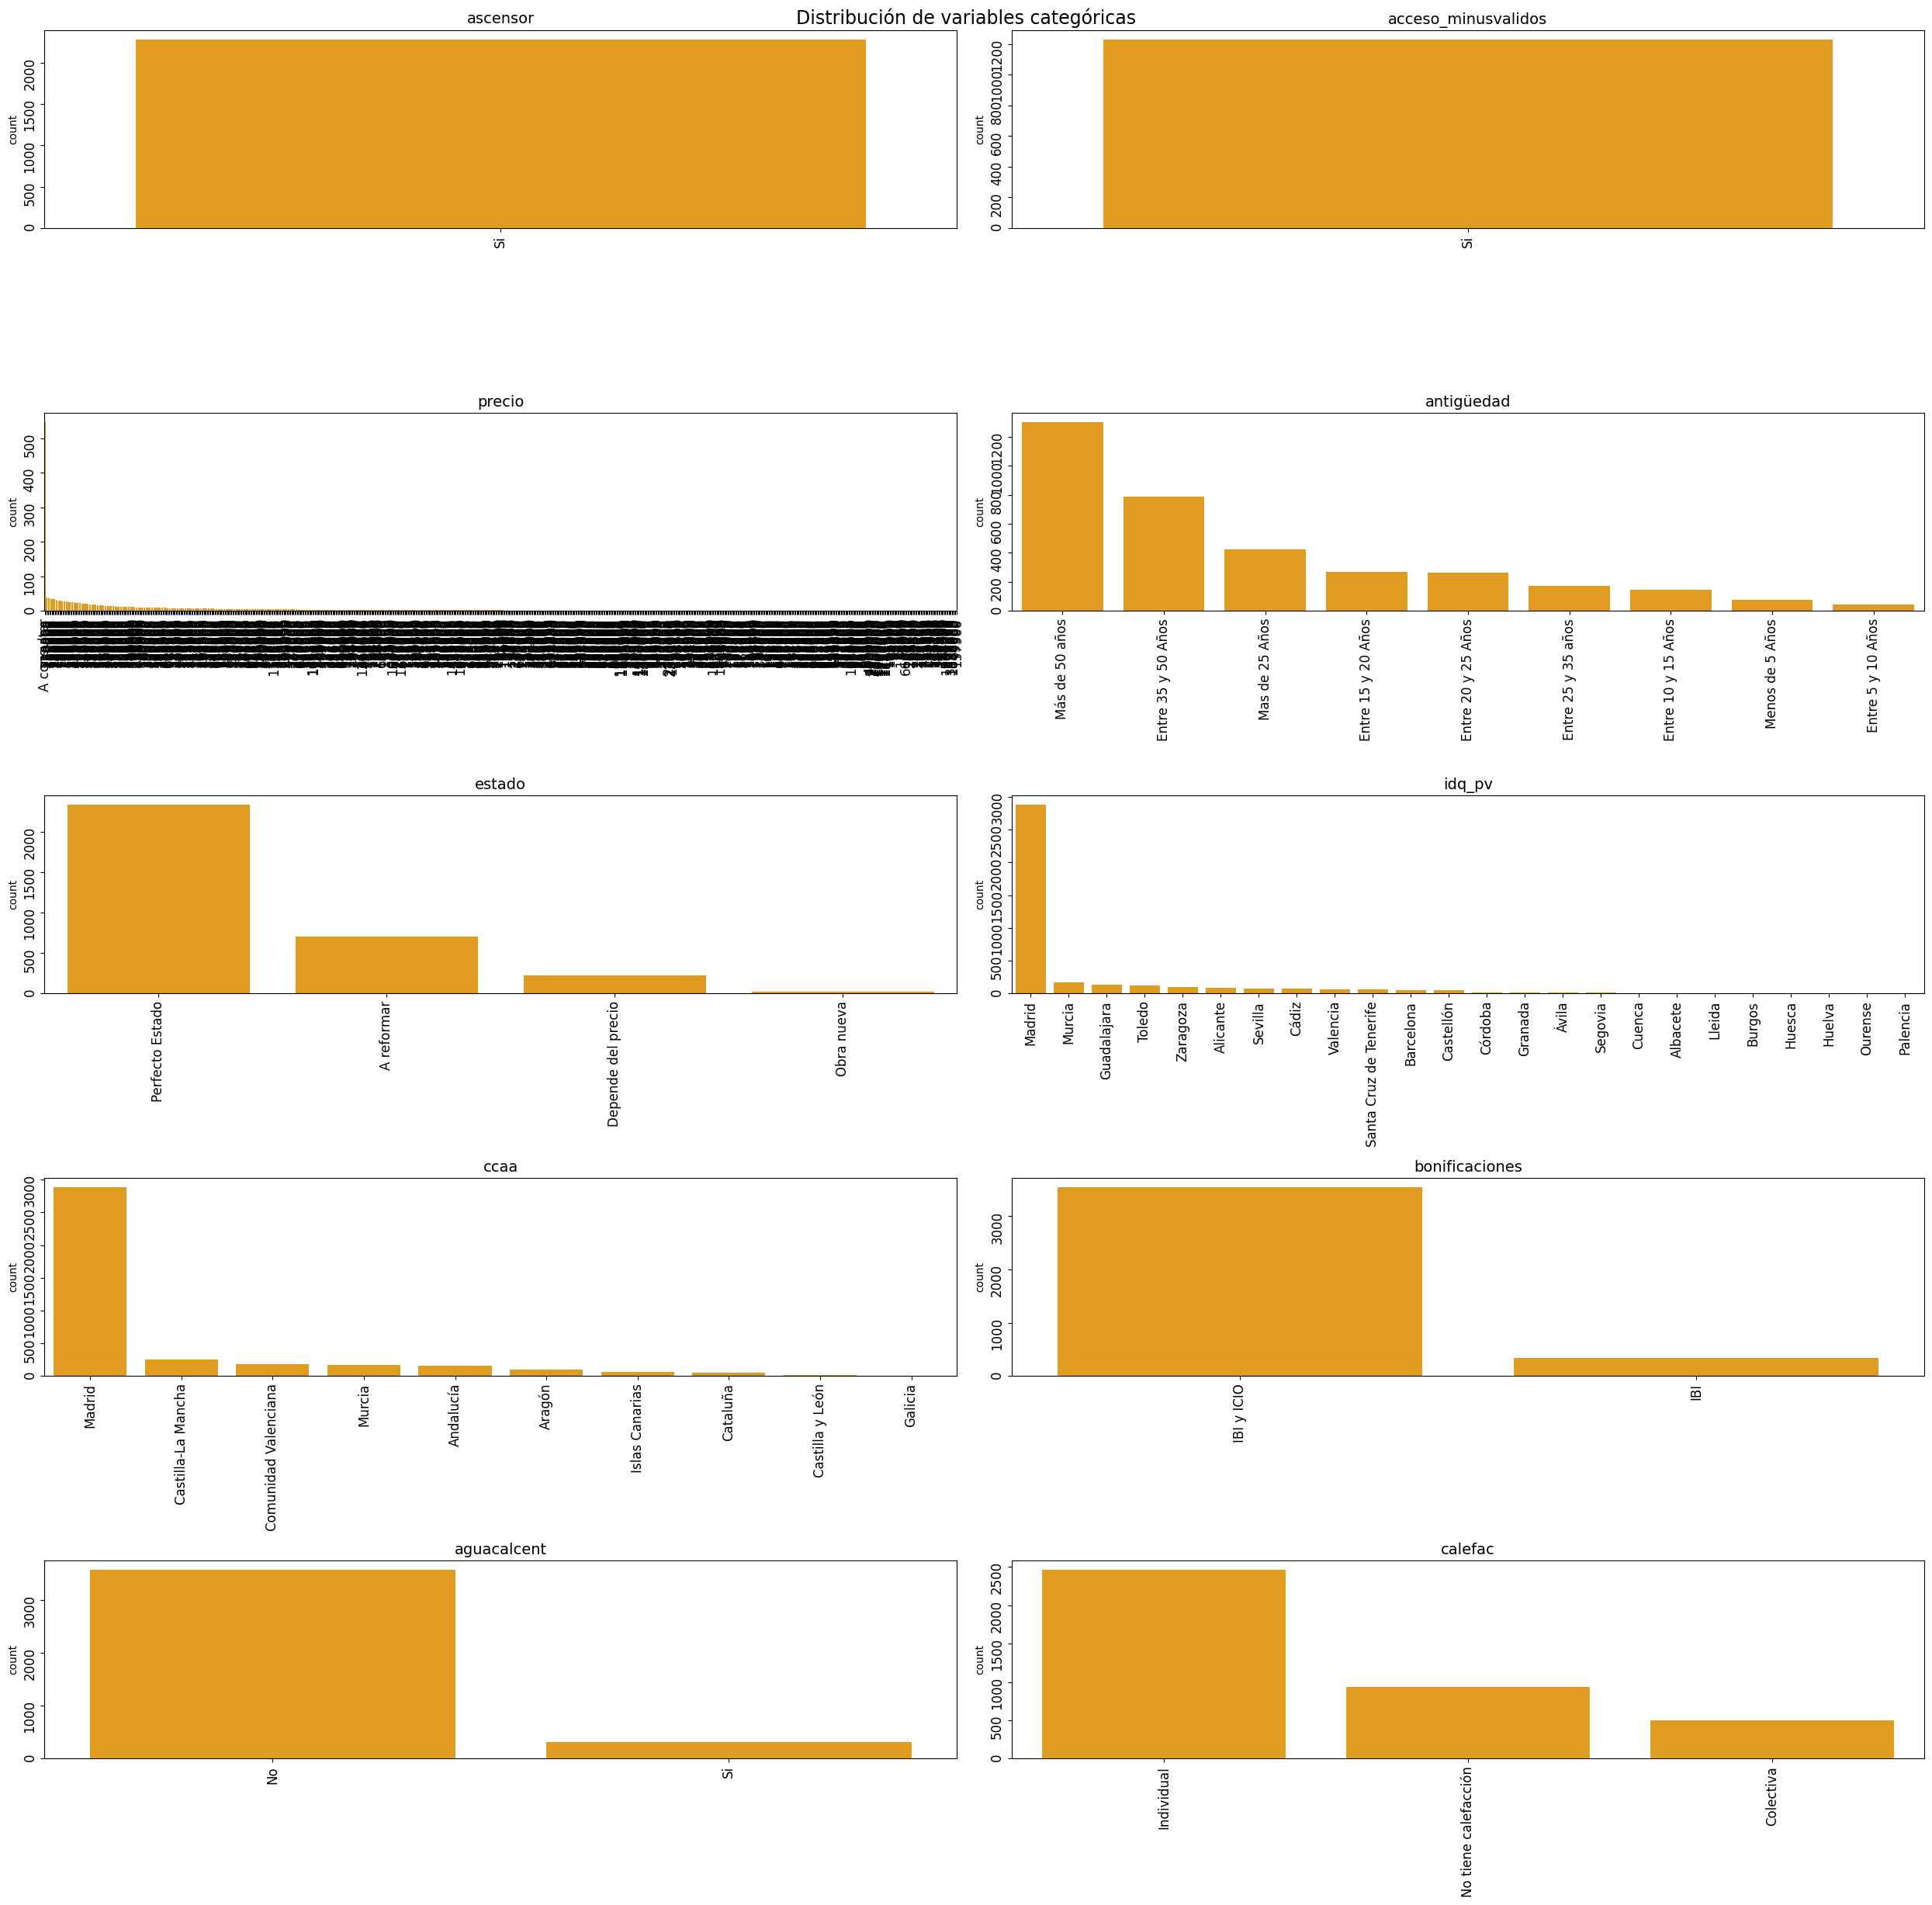

In [36]:
#Variables categóricas
visualizador.plot_categoricas( color="orange", tamanio_grafica=(25, 25), tamanio_fuente=12)

VEO LOS OUTLIERS (univariados) 

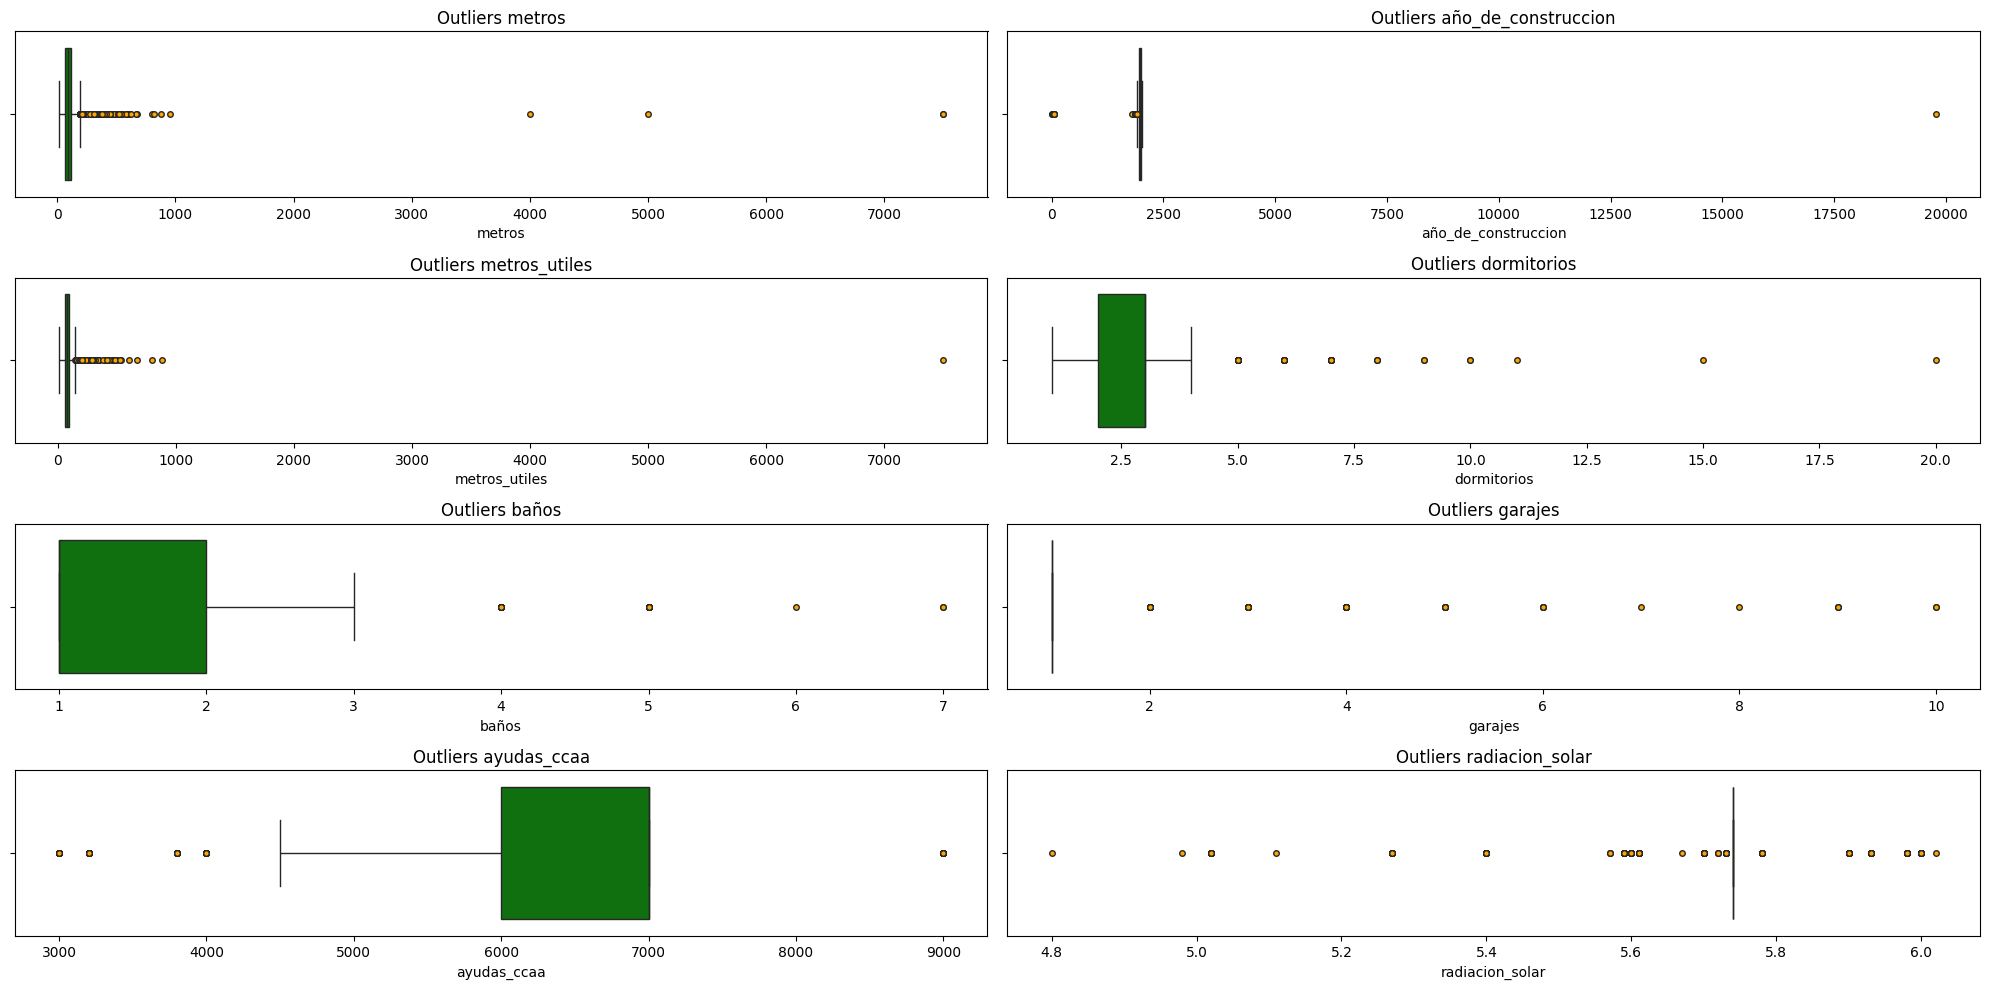

In [37]:
visualizador.deteccion_outliers(color="green")

VEO LAS CORRELACIONES

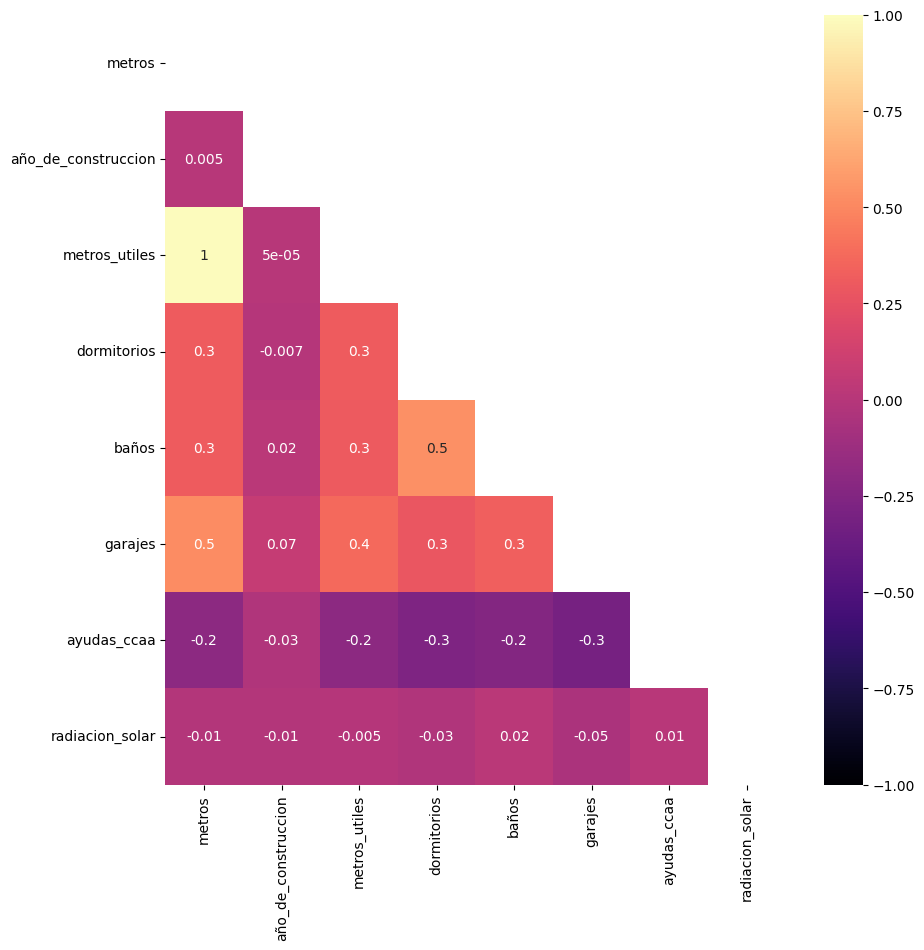

In [38]:
visualizador.correlacion(tamano_grafica=(10,10))

# EDA  
  
#### Nulos:  
Hay bastantes nulos con lo que se han seguido distintas estrategias:    
- Para columnas como ascensor o acceso minusválidos se ha creado la categoría No.  
- Para columnas como metros, dormitorios, baños y precio se usó un KNN imputer para imputar los datos y luego se redondeó  
- Para columnas como estado se creó una categoría llamada Desconocido (en varias se tuvo que hacer esto)    
  
#### Duplicados:  
- No hay duplicados   
#### Observaciones:  
- No parece haber datos erróneos    
#### Formateos según las distribuciones (gráficamente):    
- garajes, baños, dormitorios (pasarlas a categóricas)   
- año de construccion, metros (pasarlas a categóricas con intervalos) (se usaron otras columnas con menos nulos para ayudar)  
- precio (pasarla a numérica)   

#### Correlaciones:   
  
- **metros** y **metros_utiles**: Correlación positiva de **1**.(pero como se elimina no pasa nada)    
  
  
#### Outliers:   
  
Todos los outliers son perfectamente razonables y no parece que ninguno sea procedente de un dato erróneo  


**Tratamos precio**

In [39]:

df_filtrado['precio'] = df_filtrado['precio'].replace("A consultar", np.nan)


In [40]:
df_filtrado[df_filtrado["precio"]!=0].tail()

,ascensor,metros,año_de_construccion,acceso_minusvalidos,metros_utiles,dormitorios,baños,precio,antigüedad,garajes,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac
3880,NaN,71.0,1964.0,NaN,65.0,3.0,1.0,NaN,Más de 50 años,NaN,A reformar,Zaragoza,Aragón,6000,IBI,5.61,No,Individual
3881,Si,67.0,NaN,NaN,57.0,2.0,1.0,NaN,Entre 35 y 50 Años,NaN,Perfecto Estado,Zaragoza,Aragón,6000,IBI,5.61,No,Individual
3882,Si,70.0,NaN,Si,65.0,2.0,1.0,NaN,Más de 50 años,NaN,Perfecto Estado,Zaragoza,Aragón,6000,IBI,5.61,No,Colectiva
3883,NaN,86.0,1954.0,NaN,80.0,3.0,1.0,NaN,Entre 35 y 50 Años,NaN,Perfecto Estado,Zaragoza,Aragón,6000,IBI,5.61,No,Individual
3884,Si,95.0,1956.0,Si,89.0,3.0,2.0,239000,Menos de 5 Años,NaN,Perfecto Estado,Zaragoza,Aragón,6000,IBI,5.61,No,Individual


In [41]:
df_filtrado.isna().sum()

ascensor               1604
metros                    8
año_de_construccion     734
acceso_minusvalidos    2656
metros_utiles           908
dormitorios              40
baños                    16
precio                  546
antigüedad              412
garajes                2658
estado                  606
idq_pv                    0
ccaa                      0
ayudas_ccaa               0
bonificaciones            0
radiacion_solar           0
aguacalcent               0
calefac                   0
dtype: int64

***USO KNN PARA IMPUTAR NULOS***

Metros: mejor con KNN -> redondear  
Dormitorios: mejor con KNN -> redondear  
Baños: mejor con KNN -> redondear  
Año de construccion: mejor SIN KNN  


In [42]:
variables_imputar=["metros", "dormitorios", "baños", "precio"]
df_numericas=df_filtrado[variables_imputar]
imputer_knn= KNNImputer(n_neighbors=5)                   #por defecto siempre lo calcula en base a la media y no se puede cambiar
knn_imputado= imputer_knn.fit_transform(df_numericas)    #como es solo para numericas se tiene que meter el df de numericas
df_knn=df_filtrado.copy()
df_num_sin_nulos=pd.DataFrame(knn_imputado, columns= df_numericas.columns)  #para que tenga los mismo nombres de columnas
df_knn[df_numericas.columns]= df_num_sin_nulos           #Con esto metemos todo el dataframe de las numericas sin nulos donde corresponda rellenando esos nulos

Para que sean todos valores enteros

In [43]:
for var in variables_imputar:
    df_knn[var] = df_knn[var].round().astype(int)

In [44]:
df_knn["metrosvi"]=df_knn["metros"]
df_knn["naseos"]=df_knn["baños"]
df_knn["ndormito"]=df_knn["dormitorios"]
df_knn["valor"]=df_knn["precio"]
df_knn.drop(columns=variables_imputar, inplace=True)

**6 de las cuales 2 columnas se van a eliminar (antigüedad y metros_utiles), 2 realmente son categorias de si y no (ascensor y acceso_minusvalidos), 1 que se va a crear la categoría Desconocido (estado) y 1 que se va a crear la categoría No tiene garaje (garajes)**

In [45]:
(df_knn.isna().sum() != 0).sum()

np.int64(7)

In [46]:
df_knn.head()

,ascensor,año_de_construccion,acceso_minusvalidos,metros_utiles,antigüedad,garajes,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor
0,Si,1974.0,Si,120.0,Mas de 25 Años,NaN,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,Si,Colectiva,142,2,3,249000
1,Si,1974.0,Si,136.0,NaN,1.0,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,137,2,3,250000
2,Si,1987.0,Si,95.0,NaN,NaN,Perfecto Estado,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,96,2,3,223600
3,NaN,NaN,Si,40.0,Entre 35 y 50 Años,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,50,1,1,85000
4,NaN,1968.0,NaN,58.0,Más de 50 años,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,64,1,3,105000


In [47]:
df_knn[df_knn.index==544]

,ascensor,año_de_construccion,acceso_minusvalidos,metros_utiles,antigüedad,garajes,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor
544,Si,1940.0,NaN,NaN,Más de 50 años,NaN,Perfecto Estado,Madrid,Madrid,7000,IBI y ICIO,5.74,No,Individual,153,2,3,315000


In [48]:
df_knn.isna().sum()

ascensor               1604
año_de_construccion     734
acceso_minusvalidos    2656
metros_utiles           908
antigüedad              412
garajes                2658
estado                  606
idq_pv                    0
ccaa                      0
ayudas_ccaa               0
bonificaciones            0
radiacion_solar           0
aguacalcent               0
calefac                   0
metrosvi                  0
naseos                    0
ndormito                  0
valor                     0
dtype: int64

**Tratamos la columna de metros rellenando nulos y pasandolo a intervalos en una nueva columna "metrosvi"**

In [49]:
#aplicoc la función categorizar_metros a la columna 'metrosvi'
df_knn["metrosvi"] = df_knn["metrosvi"].apply(lambda x: f.categorizar_metros(float(x)) if x != "Desconocido" else x)

df_knn.drop(columns=["metros_utiles"], inplace=True)

In [50]:
df_knn["metrosvi"].value_counts()

metrosvi
Entre 76 y 90 m2      793
Entre 61 y 75 m2      700
Entre 91 y 105 m2     542
Entre 46 y 60 m2      423
Más de 180 m2         373
Entre 106 y 120 m2    368
Entre 121 y 150 m2    352
Entre 151 y 180 m2    157
Entre 31 y 45 m2      140
Hasta 30 m2            37
Name: count, dtype: int64

**Tratamos garajes**

In [51]:
df_knn["garajes"].value_counts()

garajes
1.0     955
2.0     206
3.0      30
4.0      19
5.0       6
6.0       4
9.0       3
10.0      2
7.0       1
8.0       1
Name: count, dtype: int64

In [52]:
# Crear la nueva columna aplicando la función
df_knn["nplazasgar"] = df_knn["garajes"].apply(f.categorizar_garajes)
df_knn.drop(columns=["garajes"], inplace=True)

In [53]:
df_knn["nplazasgar"].value_counts()

nplazasgar
No tiene garaje    2658
1                   955
2                   206
De 3 a 5             55
De 6 a 10            11
Name: count, dtype: int64

**Tratamos año de construcción**

In [54]:
df_knn[df_knn["año_de_construccion"].isna()].head()

,ascensor,año_de_construccion,acceso_minusvalidos,antigüedad,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor,nplazasgar
3,NaN,NaN,Si,Entre 35 y 50 Años,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,Entre 46 y 60 m2,1,1,85000,No tiene garaje
6,Si,NaN,NaN,NaN,NaN,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Entre 106 y 120 m2,1,3,135000,No tiene garaje
14,NaN,NaN,NaN,Entre 10 y 15 Años,Perfecto Estado,Alicante,Comunidad Valenciana,4000,IBI y ICIO,5.73,No,Individual,Más de 180 m2,2,4,335000,De 3 a 5
15,NaN,NaN,Si,NaN,A reformar,Alicante,Comunidad Valenciana,4000,IBI y ICIO,5.73,No,No tiene calefacción,Más de 180 m2,4,11,440000,De 3 a 5
20,NaN,NaN,NaN,Entre 25 y 35 años,NaN,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Entre 91 y 105 m2,1,3,71500,No tiene garaje


In [55]:
df_knn[df_knn["antigüedad"].isna()].head()

,ascensor,año_de_construccion,acceso_minusvalidos,antigüedad,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor,nplazasgar
1,Si,1974.0,Si,NaN,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 121 y 150 m2,2,3,250000,1
2,Si,1987.0,Si,NaN,Perfecto Estado,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 91 y 105 m2,2,3,223600,No tiene garaje
6,Si,NaN,NaN,NaN,NaN,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Entre 106 y 120 m2,1,3,135000,No tiene garaje
15,NaN,NaN,Si,NaN,A reformar,Alicante,Comunidad Valenciana,4000,IBI y ICIO,5.73,No,No tiene calefacción,Más de 180 m2,4,11,440000,De 3 a 5
31,NaN,NaN,NaN,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Más de 180 m2,2,3,550000,No tiene garaje


In [56]:
#completamos nulos en año_de_construcción usando antigüedad
df_knn["año_de_construccion"] = df_knn["año_de_construccion"].combine_first(df_knn["antigüedad"].apply(f.calcular_anio_construccion))

# creo la nueva columna annoedifinterv basada en el año de construcción
df_knn["annoedifinterv"] = df_knn["año_de_construccion"].apply(f.asignar_intervalo)

df_knn.drop(columns=["año_de_construccion", "antigüedad"], inplace=True)

In [57]:
df_knn["annoedifinterv"].unique()

array(['De 1971 a 1980', 'De 1981 a 1990', 'De 1961 a 1970',
       'Desconocido', 'De 1991 a 2000', 'De 2001 a 2010',
       'Posterior a 2010', 'De 1941 a 1950', 'De 1951 a 1960',
       'Anterior a  1900', 'De 1921 a 1940', 'De 1900 a 1920'],
      dtype=object)

In [58]:
df_knn["annoedifinterv"].value_counts()

annoedifinterv
De 1961 a 1970      868
De 1971 a 1980      766
De 2001 a 2010      517
De 1991 a 2000      442
De 1981 a 1990      287
De 1951 a 1960      277
Desconocido         189
Posterior a 2010    157
De 1921 a 1940      148
De 1941 a 1950       89
Anterior a  1900     89
De 1900 a 1920       56
Name: count, dtype: int64

In [59]:
df_knn.head(7)

,ascensor,acceso_minusvalidos,estado,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor,nplazasgar,annoedifinterv
0,Si,Si,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,Si,Colectiva,Entre 121 y 150 m2,2,3,249000,No tiene garaje,De 1971 a 1980
1,Si,Si,NaN,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 121 y 150 m2,2,3,250000,1,De 1971 a 1980
2,Si,Si,Perfecto Estado,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 91 y 105 m2,2,3,223600,No tiene garaje,De 1981 a 1990
3,NaN,Si,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,Entre 46 y 60 m2,1,1,85000,No tiene garaje,De 1971 a 1980
4,NaN,NaN,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,Entre 61 y 75 m2,1,3,105000,No tiene garaje,De 1961 a 1970
5,Si,Si,Perfecto Estado,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Entre 91 y 105 m2,1,3,110000,No tiene garaje,De 1981 a 1990
6,Si,NaN,NaN,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,No tiene calefacción,Entre 106 y 120 m2,1,3,135000,No tiene garaje,Desconocido


**Tratamos ascensor**

In [60]:
df_knn["ascensor"].fillna("No", inplace=True)

In [61]:
df_knn["ascensor"].value_counts()

ascensor
Si    2281
No    1604
Name: count, dtype: int64

**Tratamos acceso_minusvalidos**

In [62]:
dicc_acc={ "Si": "Es accesible",
           np.nan: "No es accesible"}
df_knn["accesoedif"]=df_knn["acceso_minusvalidos"].map(dicc_acc)
df_knn.drop(columns=["acceso_minusvalidos"], inplace=True)

In [63]:
df_knn["accesoedif"].value_counts()

accesoedif
No es accesible    2656
Es accesible       1229
Name: count, dtype: int64

**Tratamos estado de la siguiente manera:**   
  
Obra nueva corresponde a --> perfecto  
Perfecto Estado corresponde a --> casi perfecto  
A reformar corresponde a --> levemente mejorable  
Depende del precio corresponde a --> mejorable  
Nulos corresponden a --> Desconocido  
  
*A estas conclusiones se han llegado tras inspeccionar en la web los tipos de viviendas de cada estado*  

In [64]:
dicc_est= {
    'Obra nueva': 'perfecto',
    'Perfecto Estado': 'casi perfecto',
    'A reformar': 'levemente mejorable',
    'Depende del precio': 'mejorable'}

df_knn['estadoedif'] = df_knn['estado'].map(dicc_est).fillna('Desconocido')
df_knn.drop(columns=["estado"], inplace=True)

In [65]:
df_knn["estadoedif"].value_counts()

estadoedif
casi perfecto          2335
levemente mejorable     700
Desconocido             606
mejorable               219
perfecto                 25
Name: count, dtype: int64

In [66]:
df_knn.isna().sum()

ascensor           0
idq_pv             0
ccaa               0
ayudas_ccaa        0
bonificaciones     0
radiacion_solar    0
aguacalcent        0
calefac            0
metrosvi           0
naseos             0
ndormito           0
valor              0
nplazasgar         0
annoedifinterv     0
accesoedif         0
estadoedif         0
dtype: int64

In [67]:
df_knn["naseos"]=df_knn["naseos"].astype("O")
df_knn["ndormito"]=df_knn["ndormito"].astype("O")

***YA NO TENEMOS NULOS Y HEMOS FORMATEADO TANTO LOS ENCABEZADOS COMO LOS VALORES***

In [68]:
df_knn.head()

,ascensor,idq_pv,ccaa,ayudas_ccaa,bonificaciones,radiacion_solar,aguacalcent,calefac,metrosvi,naseos,ndormito,valor,nplazasgar,annoedifinterv,accesoedif,estadoedif
0,Si,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,Si,Colectiva,Entre 121 y 150 m2,2,3,249000,No tiene garaje,De 1971 a 1980,Es accesible,Desconocido
1,Si,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 121 y 150 m2,2,3,250000,1,De 1971 a 1980,Es accesible,Desconocido
2,Si,Albacete,Castilla-La Mancha,4500,IBI y ICIO,5.72,No,Individual,Entre 91 y 105 m2,2,3,223600,No tiene garaje,De 1981 a 1990,Es accesible,casi perfecto
3,No,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,Entre 46 y 60 m2,1,1,85000,No tiene garaje,De 1971 a 1980,Es accesible,casi perfecto
4,No,Alicante,Comunidad Valenciana,6000,IBI y ICIO,5.73,No,Individual,Entre 61 y 75 m2,1,3,105000,No tiene garaje,De 1961 a 1970,No es accesible,casi perfecto


# **EDA (ya formateadas)**

In [69]:
f.exploracion_dataframe(df_knn, "valor")

El número de datos es 3885 y el de columnas es 16

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 45

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
ascensor,object
idq_pv,object
ccaa,object
ayudas_ccaa,int64
bonificaciones,object
radiacion_solar,float64
aguacalcent,object
calefac,object
metrosvi,object
naseos,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna ASCENSOR tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
ascensor,
Si,2281
No,1604


La columna IDQ_PV tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 24 categorías (5/24)


,count
idq_pv,
Madrid,2880
Murcia,169
Guadalajara,133
Toledo,117
Zaragoza,101


La columna CCAA tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 10 categorías (5/10)


,count
ccaa,
Madrid,2880
Castilla-La Mancha,256
Comunidad Valenciana,184
Murcia,169
Andalucía,163


La columna BONIFICACIONES tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
bonificaciones,
IBI y ICIO,3541
IBI,344


La columna AGUACALCENT tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
aguacalcent,
No,3566
Si,319


La columna CALEFAC tiene los siguientes valores únicos:
Mostrando 3 categorías con más valores del total de 3 categorías (3/3)


,count
calefac,
Individual,2457
No tiene calefacción,932
Colectiva,496


La columna METROSVI tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 10 categorías (5/10)


,count
metrosvi,
Entre 76 y 90 m2,793
Entre 61 y 75 m2,700
Entre 91 y 105 m2,542
Entre 46 y 60 m2,423
Más de 180 m2,373


La columna NASEOS tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 7 categorías (5/7)


,count
naseos,
1,2179
2,1366
3,259
4,65
5,13


La columna NDORMITO tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 13 categorías (5/13)


,count
ndormito,
3,1844
2,965
4,593
1,301
5,112


La columna NPLAZASGAR tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 5 categorías (5/5)


,count
nplazasgar,
No tiene garaje,2658
1,955
2,206
De 3 a 5,55
De 6 a 10,11


La columna ANNOEDIFINTERV tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 12 categorías (5/12)


,count
annoedifinterv,
De 1961 a 1970,868
De 1971 a 1980,766
De 2001 a 2010,517
De 1991 a 2000,442
De 1981 a 1990,287


La columna ACCESOEDIF tiene los siguientes valores únicos:
Mostrando 2 categorías con más valores del total de 2 categorías (2/2)


,count
accesoedif,
No es accesible,2656
Es accesible,1229


La columna ESTADOEDIF tiene los siguientes valores únicos:
Mostrando 5 categorías con más valores del total de 5 categorías (5/5)


,count
estadoedif,
casi perfecto,2335
levemente mejorable,700
Desconocido,606
mejorable,219
perfecto,25



----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
ayudas_ccaa,3885.0,6423.423423,1106.577152,3000.0,6000.00,7000.00,7000.00,9000.00
radiacion_solar,3885.0,5.728790,0.089073,4.8,5.74,5.74,5.74,6.02
valor,3885.0,272549.367310,254848.511321,185.0,150000.00,209180.00,315000.00,6600000.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
ascensor,3885,2,Si,2281
idq_pv,3885,24,Madrid,2880
ccaa,3885,10,Madrid,2880
bonificaciones,3885,2,IBI y ICIO,3541
aguacalcent,3885,2,No,3566
calefac,3885,3,Individual,2457
metrosvi,3885,10,Entre 76 y 90 m2,793
naseos,3885,7,1,2179
ndormito,3885,13,3,1844
nplazasgar,3885,5,No tiene garaje,2658



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ascensor         3885 non-null   object 
 1   idq_pv           3885 non-null   object 
 2   ccaa             3885 non-null   object 
 3   ayudas_ccaa      3885 non-null   int64  
 4   bonificaciones   3885 non-null   object 
 5   radiacion_solar  3885 non-null   float64
 6   aguacalcent      3885 non-null   object 
 7   calefac          3885 non-null   object 
 8   metrosvi         3885 non-null   object 
 9   naseos           3885 non-null   object 
 10  ndormito         3885 non-null   object 
 11  valor            3885 non-null   int64  
 12  nplazasgar       3885 non-null   object 
 13  annoedifinterv   3885 non-null   object 
 14  accesoedif       3885 non-null   object 
 15  estadoedif       3885 non-null   object 
d

None

VEO LA DISTRIBUCIÓN DE LAS VARIABLES NUMÉRICAS

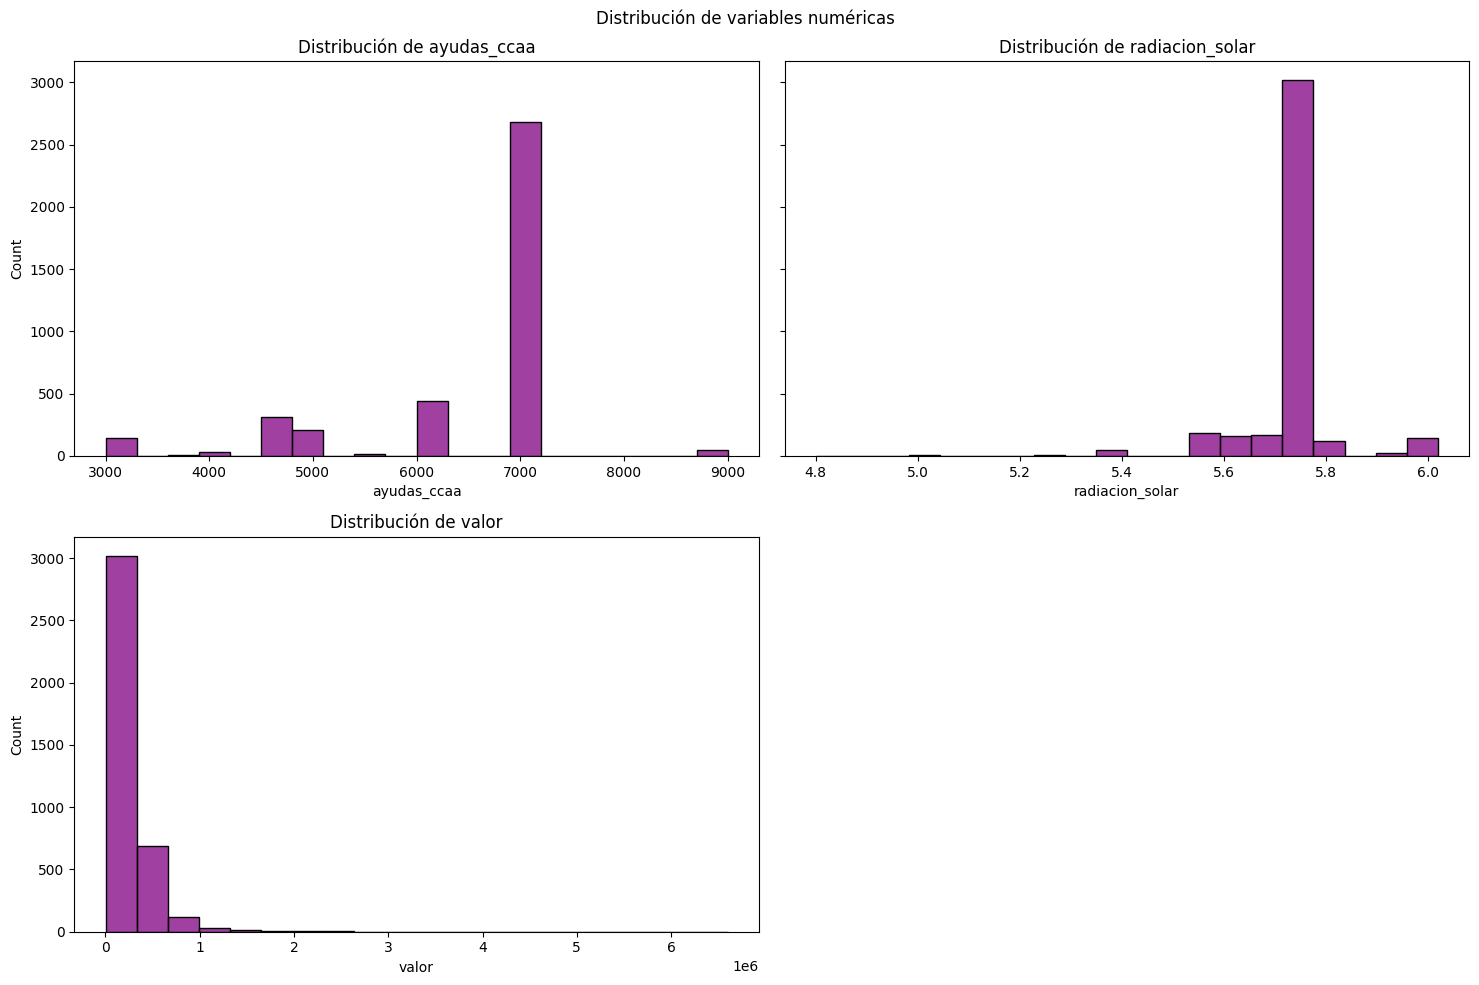

In [70]:
visualizador=f.Visualizador(df_knn)
visualizador.plot_numericas(color="purple", tamano_grafica=(15, 10))

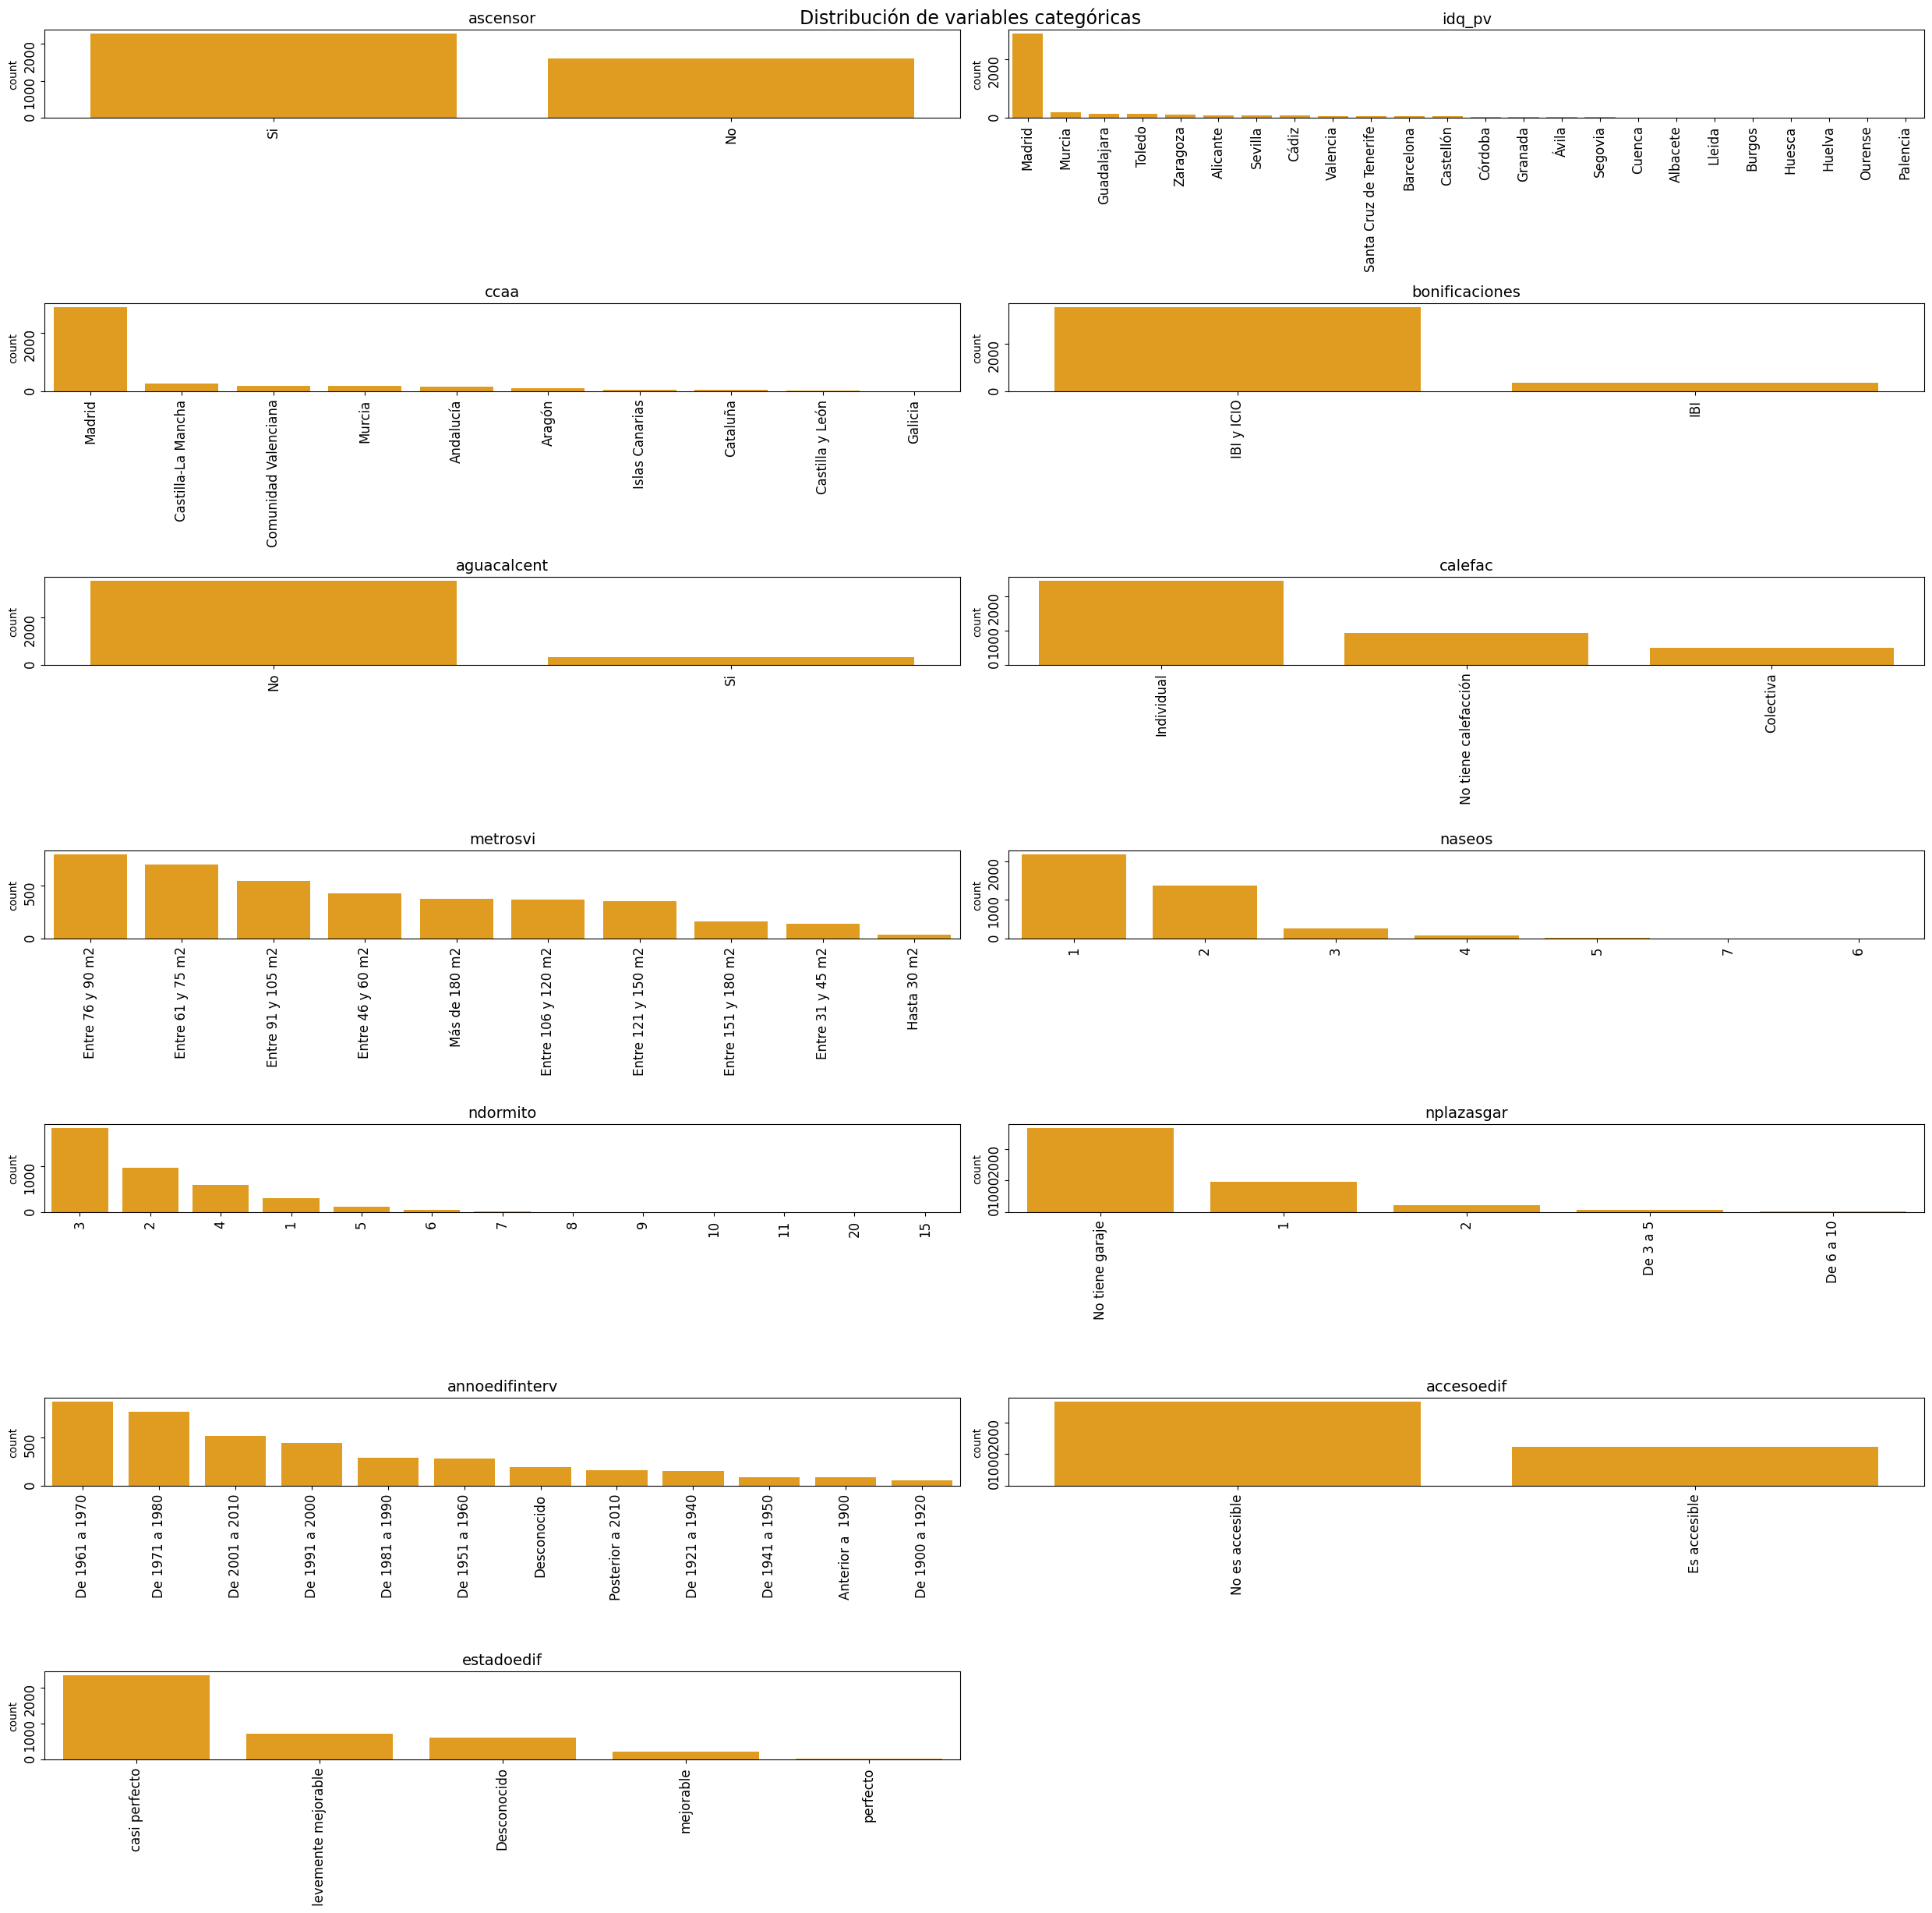

In [71]:
#Variables categóricas
visualizador.plot_categoricas( color="orange", tamanio_grafica=(25, 25), tamanio_fuente=12)

VEO LOS OUTLIERS (univariados) 

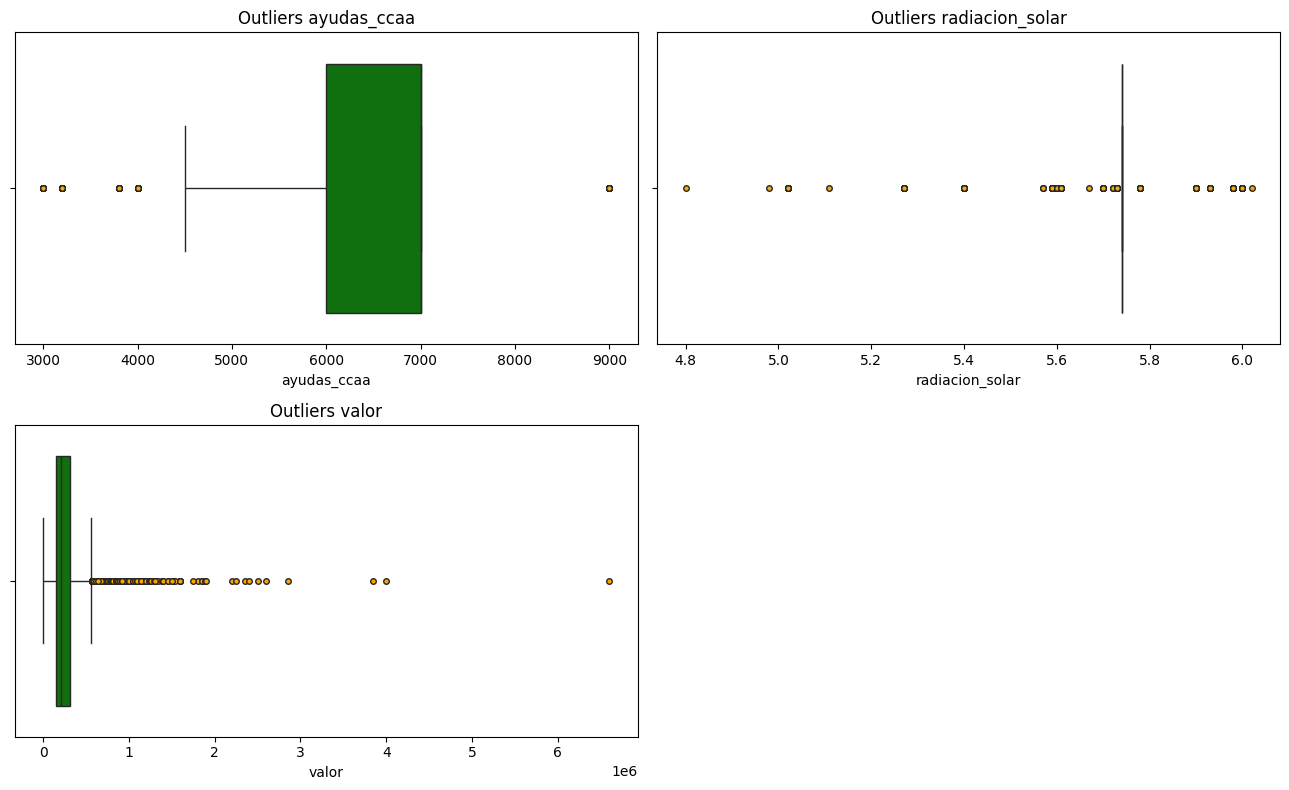

In [72]:
visualizador.deteccion_outliers(color="green", tamano_grafica=(13, 8))

VEO LAS CORRELACIONES

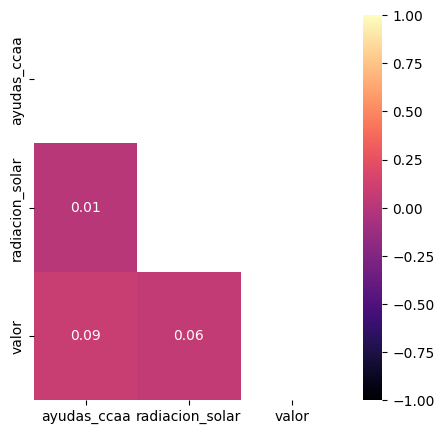

In [73]:
visualizador.correlacion(tamano_grafica=(5,5))

In [74]:
df_knn.to_pickle("../datos/red_piso/Datos_filtrados/datos_pisos_filtrados.pkl")